# Compare properties of native and decoy interfaces

## Import Python modules

In [1]:
import os
import sys
import pandas
import glob
import random
import re
import shutil
import math
import subprocess
import time
import numpy as np
import scipy.stats
import umap
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.5, style='ticks', palette='colorblind')

# custom modules
sys.path.append('scripts/')
import design_utils

resultsdir = '/net/scratch/haddox/2021/ppi_benchmark/results'
if not os.path.isdir(resultsdir):
    os.makedirs(resultsdir)

Compute the change in SASA upon binding for each decoy from each landscape

In [2]:
# Get silent files
silent_files_for_optE_dir = 'silent_files_for_optE_ddg_top12000_noS'
e_function_from_relax = 'beta_nov16' # 'HH_run23A_step384'
if e_function_from_relax == 'beta_nov16':
    input_silent_files = glob.glob(os.path.join(
        f'results/{silent_files_for_optE_dir}/',
        '*_complex.out'
    ))
else:
    input_silent_files = glob.glob(os.path.join(
        f'results/{silent_files_for_optE_dir}/',
        f'{e_function_from_relax}_silent_files',
        '*_complex.out'
    ))

# Input variables for dSASA
probe_radius = 1.4 # 2.1 # 

# Input varaibles for structural metrics
rosettapath = '/home/haddox/Rosetta/main/source/bin/rosetta_scripts.default.linuxgccrelease'
xml_file = 'scripts/structural_metrics.xml'
weights_file = 'beta_nov16_cart'

# Cycle over silent files and compute things
all_natives = []
for input_silent_file in input_silent_files:
    
    # Compute dSASA values
    native = os.path.basename(input_silent_file)[:4]
    all_natives.append(native)
    output_file = input_silent_file.replace(
        '.out',
        f'_delta_sasa_{probe_radius}.csv'
    )
    cmd = ' '.join([
        'python',
        'scripts/compute_delta_sasa_of_binding.py',
        f'--input_silent_file {input_silent_file}',
        f'--probe_radius {probe_radius}',
        f'--output_file {output_file}'
    ])
    sbatch_file_name = output_file.replace('.csv', '.sbatch')
    if not os.path.isfile(sbatch_file_name):
        design_utils.WriteSbatchFile(
            sbatch_file_name,
            command=cmd,
            queue_type='short',
            memory='2g'
        ) 
        ! sbatch {sbatch_file_name}
        
    # Compute other structural metrics
    output_file = input_silent_file.replace(
        '.out',
        f'_structural_metrics.sc'
    )
    cmd = ' '.join([
        rosettapath,
        f'-in:file:silent {input_silent_file}',
        '-in:file:silent_struct_type binary',
        '-parser:protocol {0}'.format(xml_file),
        #'-out:prefix {0}'.format(output_dir),
        f'-out:file:scorefile {output_file}',
        '-out:file:score_only',
        '-parser:script_vars',
        'weights_file={0}'.format(weights_file),
        '-beta_nov16_cart',
        '-corrections::beta_nov16',
        '-crystal_refine true',
        '-holes:dalphaball /home/sheffler/bin/DAlphaBall.gcc',
    ])
    sbatch_file_name = output_file.replace('.sc', '.sbatch')
    if not os.path.isfile(sbatch_file_name):
        design_utils.WriteSbatchFile(
            sbatch_file_name,
            command=cmd,
            queue_type='short',
            memory='2g'
        )
        ! sbatch {sbatch_file_name}

Read in scores for a specific native

In [3]:
native = '1KAC' # '1E4K' # '1K4C' # '1SBB' # '1ZHH' # '1OFU' # '1AKJ' # '1NCA' # '2AJF' # '1WEJ' # '1GHQ' # '2HRK' # '1I9R' #'1SBB' # '1EZU' # '2VIS' # 
e_function_from_relax = 'beta_nov16' # 'HH_run23A_step384' # 

# Read in delta SASA values
if e_function_from_relax == 'beta_nov16':
    delta_sasa_f = os.path.join(
        f'results/{silent_files_for_optE_dir}/',
        f'{native}_complex_delta_sasa_1.4.csv'
    )
    sm_f = os.path.join(
        f'results/{silent_files_for_optE_dir}/',
        f'{native}_complex_structural_metrics.sc'
    )
    scores_f = f'results/{silent_files_for_optE_dir}/{native}.sc'
else:
    delta_sasa_f = os.path.join(
        f'results/{silent_files_for_optE_dir}/',
        f'{e_function_from_relax}_silent_files',
        f'{native}_complex_delta_sasa_1.4.csv'
    )
    sm_f = os.path.join(
        f'results/{silent_files_for_optE_dir}/',
        f'{e_function_from_relax}_silent_files',
        f'{native}_complex_structural_metrics.sc'
    )
    scores_f = os.path.join(
        f'results/{silent_files_for_optE_dir}/',
        f'{e_function_from_relax}_silent_files',
        f'{native}.sc'
    )
delta_sasa_df = pandas.read_csv(delta_sasa_f)

# Read in structural metrics
sm_df = pandas.read_csv(sm_f, skiprows=1, sep='\s+')
sm_df['pdb'] = sm_df['description'].apply(
    lambda x: os.path.basename(x)[:-5]
)

# Read in scores
scores_df = pandas.read_csv(scores_f, sep='\s+')
scores_df = scores_df.merge(delta_sasa_df, on='pdb')
cols_to_merge = [
    col for col in sm_df.columns.values
    if col not in scores_df.columns.values
] + ['pdb']
scores_df = scores_df.merge(sm_df[cols_to_merge], on='pdb')
scores_df['decoy_type'] = scores_df['rmsd'].apply(
    lambda x: 'native' if x < 1.5 else 'decoy'
)
scores_df['all_buns'] = scores_df[[
    'buns_bb_heavy', 'buns_nonheavy', 'buns_sc_heavy'
]].sum(axis=1)
scores_df['all_heavy_buns'] = scores_df[[
    'buns_bb_heavy', 'buns_sc_heavy'
]].sum(axis=1)

Plot data for a specific metric

In [4]:
sns.set(font_scale=2, style='ticks', palette='colorblind')

Clipping ddg at 30
1KAC buns_heavy_ball_1.1D diff


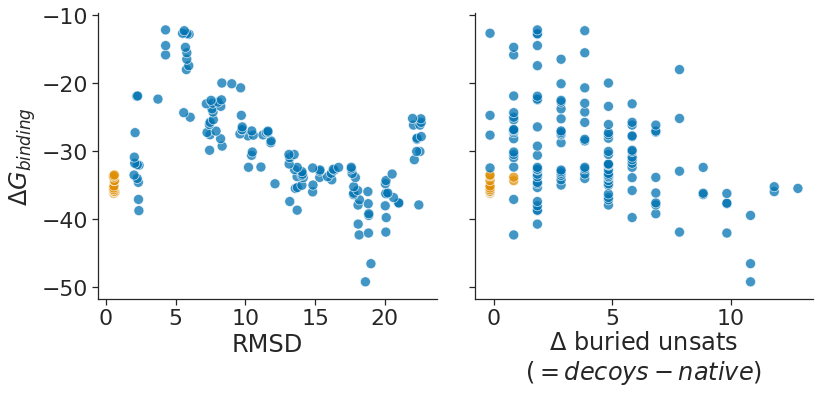

1KAC all_heavy_buns diff


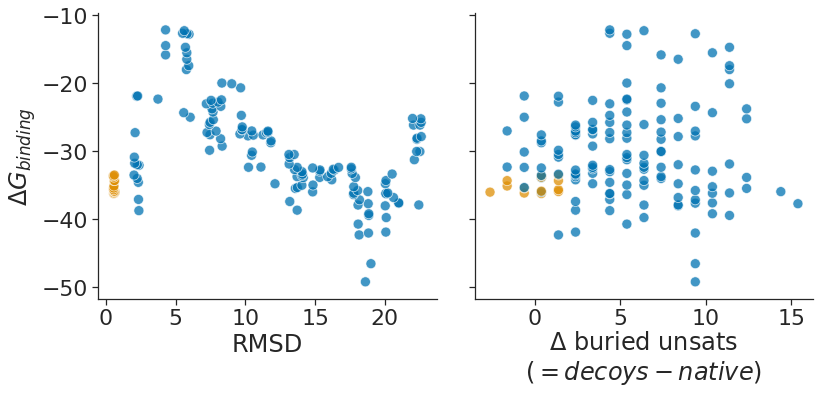

1KAC dsasa_all ratio


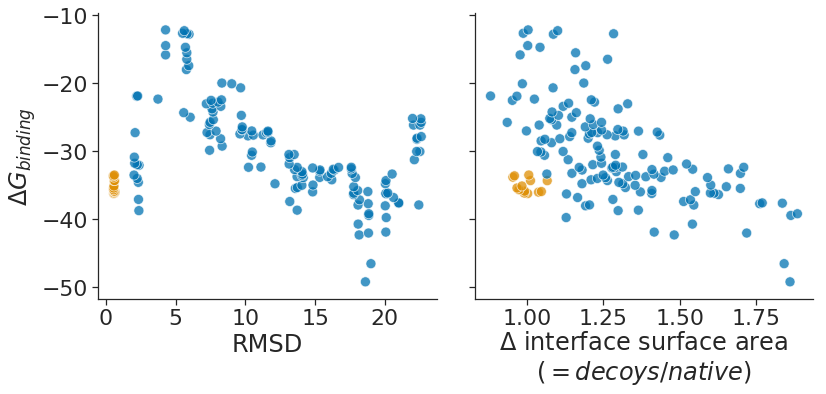

In [5]:
metrics_dict = {
    'buns_heavy_ball_1.1D' : {
        'delta_type' : 'diff',
        'xlabel' : '$\Delta$ buried unsats\n$(=decoys - native)$',
    },
    'all_heavy_buns' : {
        'delta_type' : 'diff',
        'xlabel' : '$\Delta$ buried unsats\n$(=decoys - native)$',
    },
    'dsasa_all' : {
        'delta_type' : 'ratio',
        'xlabel' : '$\Delta$ interface surface area\n$(=decoys/native)$'
    },
}
ddg_upper_bound = 30
print(f'Clipping ddg at {ddg_upper_bound}')
for (metric, metric_dict) in metrics_dict.items():
    
    (fix, axs) = plt.subplots(
        ncols=2, figsize=[12,6],
        sharey=True, # sharex=True, 
    )
    
    metric_to_plot = metric_dict['delta_type'] # 'diff' # 'ratio' #  
    print(native, metric, metric_to_plot)
    
    # Get average SASA of near-natives
    mean_val_nn = scores_df[scores_df['rmsd'] < 1.5][metric].mean()
    
    # Compute differences in metrics
    data = scores_df[
        #((scores_df['rmsd'] < 1.5) |
        (~scores_df['rmsd'].isnull())
    ].copy()
    data['ddg'] = data['ddg'].clip(upper=ddg_upper_bound)
    data['metric_ratio'] = data[metric] / mean_val_nn
    data['metric_diff'] = data[metric] - mean_val_nn
    
    # Plot data
    sns.scatterplot(
        x='rmsd', y='ddg', data=data, ax=axs[0],
        hue='decoy_type', hue_order=['decoy', 'native'],
        s=100, alpha=0.75
    )
    axs[0].set(
        xlabel='RMSD',
        ylabel='$\Delta G_{binding}$'
    )
    sns.scatterplot(
        x=f'metric_{metric_to_plot}', y='ddg', data=data, ax=axs[1],
        hue='decoy_type', hue_order=['decoy', 'native'],
        s=100, alpha=0.75
    )
    axs[1].set(
        xlabel=metric_dict['xlabel'],
    )

    for i in [0, 1]:
        axs[i].get_legend().remove()
    #plt.ylabel(metric)
    sns.despine()
    plt.tight_layout()
    plt.show()

In [22]:
data.sort_values('ddg', ascending=True, inplace=True)
data[
    data['rmsd'] > 6
][['rmsd', 'ddg', 'metric_diff', 'metric_ratio']][:5]#['metric_diff'][:5]

,rmsd,ddg,metric_diff,metric_ratio
0,22.149,-61.520,-3319.628044,2.825154
1,20.912,-59.928,-2985.824183,2.641626
2,18.702,-57.430,-2043.593331,2.123581
3,24.077,-55.331,-2752.509313,2.513348
4,17.177,-55.150,-4406.855358,3.422919


Plot correlation between ddG and dSASA

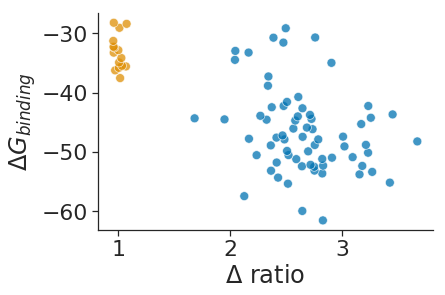

In [23]:
sns.scatterplot(
    x=f'metric_{metric_to_plot}', y='ddg', data=data,
    hue='decoy_type', hue_order=['decoy', 'native'],
    s=80, alpha=0.75
)
plt.xlabel(f'$\Delta$ {metric_to_plot}')
plt.ylabel('$\Delta G_{binding}$')
plt.legend().remove()
sns.despine()
plt.show()

Compute changes in metrics between near-natives and >6A decoys for each landscape.

In [58]:
# Read in data on SASA
e_function_from_relax = 'beta_nov16' # 'HH_run23A_step384' # 
sasa_metrics = ['dsasa_all', 'dsasa_polar', 'dsasa_non_polar']
buns_metrics = ['buns_heavy_ball_1.1D', 'all_buns', 'all_heavy_buns']
changes_dict = {
    key : []
    for key in ['native'] + sasa_metrics + buns_metrics
}
probe_size = 1.4 # 2.1 # 
if e_function_from_relax == 'beta_nov16':
    delta_sasa_fs = glob.glob(os.path.join(
        f'results/{silent_files_for_optE_dir}/',
        f'*_complex_delta_sasa_{probe_size}.csv'
    ))
else:
    delta_sasa_fs = glob.glob(os.path.join(
        f'results/{silent_files_for_optE_dir}/',
        f'{e_function_from_relax}_silent_files',
        f'*_complex_delta_sasa_{probe_size}.csv'
    ))
for native in all_natives:
    
    # Read in dSASA values
    changes_dict['native'].append(native)
    if e_function_from_relax == 'beta_nov16':
        delta_sasa_f = os.path.join(
            f'results/{silent_files_for_optE_dir}/',
            f'{native}_complex_delta_sasa_{probe_size}.csv'
        )
        sm_f = os.path.join(
            f'results/{silent_files_for_optE_dir}/',
            f'{native}_complex_structural_metrics.sc'
        )
        scores_f = os.path.join(
            f'results/{silent_files_for_optE_dir}/',
            f'{native}.sc'
        )
    else:
        delta_sasa_f = os.path.join(
            f'results/{silent_files_for_optE_dir}/',
            f'{e_function_from_relax}_silent_files',
            f'{native}_complex_delta_sasa_{probe_size}.csv'
        )
        sm_f = os.path.join(
            f'results/{silent_files_for_optE_dir}/',
            f'{e_function_from_relax}_silent_files',
            f'{native}_complex_structural_metrics.sc'
        )
        scores_f = os.path.join(
            f'results/{silent_files_for_optE_dir}/',
            f'{e_function_from_relax}_silent_files',
            f'{native}.sc'
        )
    delta_sasa_df = pandas.read_csv(delta_sasa_f)

    # Read in structural metrics
    sm_df = pandas.read_csv(sm_f, skiprows=1, sep='\s+')
    sm_df['pdb'] = sm_df['description'].apply(
        lambda x: os.path.basename(x)[:-5]
    )
    
    # Read in scores
    scores_df = pandas.read_csv(scores_f, sep='\s+')
    scores_df = scores_df.merge(delta_sasa_df, on='pdb')
    cols_to_merge = [
        col for col in sm_df.columns.values
        if col not in scores_df.columns.values
    ] + ['pdb']
    scores_df = scores_df.merge(sm_df[cols_to_merge], on='pdb')
    scores_df['all_buns'] = scores_df[[
        'buns_bb_heavy', 'buns_nonheavy', 'buns_sc_heavy'
    ]].sum(axis=1)
    scores_df['all_heavy_buns'] = scores_df[[
        'buns_bb_heavy', 'buns_sc_heavy'
    ]].sum(axis=1)
    
    # Compute difference in buns
    for buns_metric in buns_metrics:
        
        # Compute mean value of near natives, then compute diff
        mean_val_nn = scores_df[scores_df['rmsd'] < 1.5][buns_metric].mean()
        scores_df['buns_diff'] = scores_df[buns_metric] - mean_val_nn    
        
        # Get data for natives and the 5 best-scoring decoys >6A
        native_df = scores_df[scores_df['rmsd'] < 1.5].copy()
        native_buns_diff = native_df['buns_diff'].mean()
        
        decoy_cutoff = 6
        decoy_df = scores_df[scores_df['rmsd'] > decoy_cutoff].copy()
        decoy_df.sort_values('ddg', ascending=True, inplace=True)
        decoy_buns_diff = decoy_df['buns_diff'][:5].mean()

        changes_dict[buns_metric].append(
            decoy_buns_diff - native_buns_diff
        )
    
    # Compute dSASA ratios
    for sasa_metric in sasa_metrics:
        
        # Compute mean value of near natives, then compute ratio
        mean_val_nn = scores_df[scores_df['rmsd'] < 1.5][sasa_metric].mean()
        scores_df['dsasa_ratio'] = scores_df[sasa_metric] / mean_val_nn

        # Get data for natives and the 5 best-scoring decoys >6A
        native_df = scores_df[scores_df['rmsd'] < 1.5].copy()
        native_dsasa_ratio = native_df['dsasa_ratio'].mean()

        decoy_df = scores_df[scores_df['rmsd'] > 6].copy()
        decoy_df.sort_values('ddg', ascending=True, inplace=True)
        decoy_dsasa_ratio = decoy_df['dsasa_ratio'][:5].mean()

        changes_dict[sasa_metric].append(
            decoy_dsasa_ratio/native_dsasa_ratio
        )
        
changes_df = pandas.DataFrame(changes_dict)

Read in discrimination scores

In [59]:
ds_dict = {
    key : []
    for key in ['native', 'ds']
}
n_total_samples = 150
fs = glob.glob(f'results/score_docking_result_optE_input_{e_function_from_relax}*top{n_total_samples}')
for f in fs:
    if 'natives_100' in f:
        continue
    with open(f) as f_open:
        lines = f_open.readlines()
        for line in lines:
            elements = line.strip().split()
            if len(elements) != 2:
                continue
            native = os.path.basename(elements[0])[:4]
            score = float(elements[1])
            ds_dict['native'].append(native)
            ds_dict['ds'].append(score)
ds_df = pandas.DataFrame(ds_dict)

Merge data and put upper limit on a few of the columns

In [60]:
df = changes_df.merge(ds_df, on='native', how='inner')
df['dsasa_all'] = df['dsasa_all'].clip(upper=3)
df['all_heavy_buns'] = df['all_heavy_buns'].clip(upper=20)
df['buns_heavy_ball_1.1D'] = df['buns_heavy_ball_1.1D'].clip(upper=10)

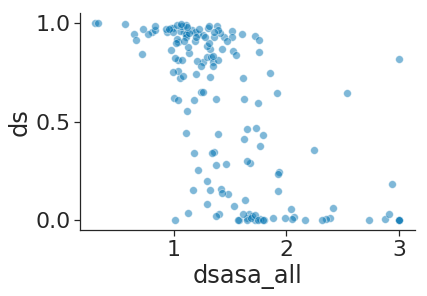

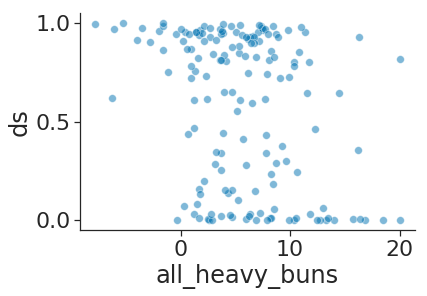

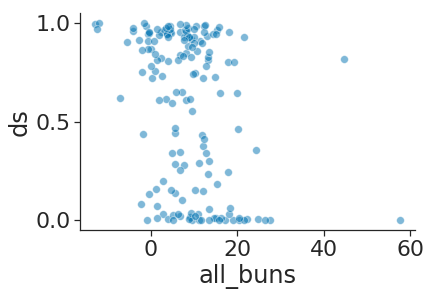

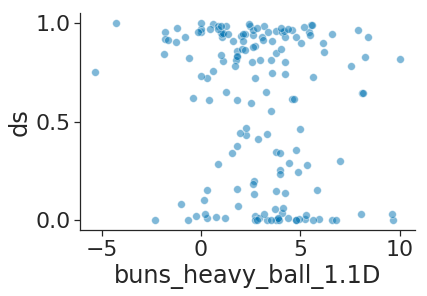

In [61]:
sasa_metrics = [
    'dsasa_all', #'dsasa_polar', 'dsasa_non_polar'
    'all_heavy_buns', 'all_buns',
    'buns_heavy_ball_1.1D',
]
for metric in sasa_metrics:
    sns.scatterplot(
        x=metric, y='ds', data=df,
        s=60, alpha=0.5
    )
    #plt.ylabel('discrimination score')
    sns.despine()
    plt.show()

In [62]:
df[
    df['native'].str.contains('1K4C')
].sort_values('all_buns', ascending=False).head()

,native,dsasa_all,dsasa_polar,dsasa_non_polar,buns_heavy_ball_1.1D,all_buns,all_heavy_buns,ds
94,1K4C,2.874492,2.07669,3.471366,5.236364,22.345455,16.345455,0.004596


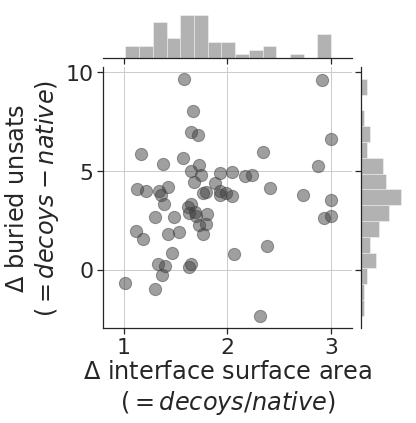

In [84]:
data = df[df['ds'] < 0.5]
g = sns.jointplot(
    x='dsasa_all', y='buns_heavy_ball_1.1D', data=data,
    marginal_kws=dict(bins=15),
    s=150, alpha=0.5, color='0.25'
    #hue='ds'
)
g.ax_joint.grid()
g.ax_joint.set(
    xlim=[0.8, 3.2],
    xlabel='$\Delta$ interface surface area\n$(=decoys / native)$',
    ylabel='$\Delta$ buried unsats\n$(=decoys - native)$',
)
plt.show()

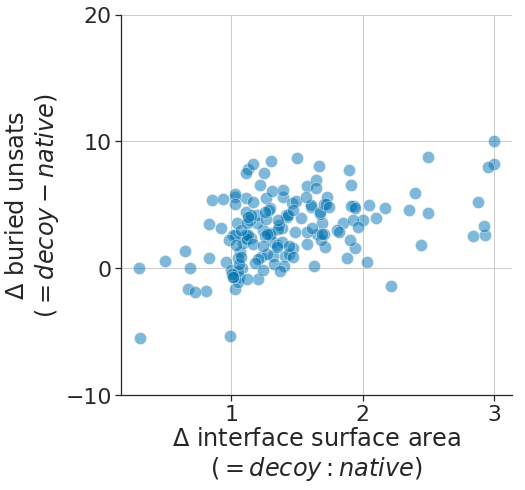

In [43]:
df.sort_values('ds', ascending=False, inplace=True)
plt.figure(figsize=[7,7])
sns.scatterplot(
    x='dsasa_all', y='buns_heavy_ball_1.1D', data=df,
    s=150, alpha=0.5
    #hue='ds'
)
# data = df[df['native'].isin(['1PVH', '1KAC', '1KLU', '1K4C'])]
# sns.scatterplot(
#     x='dsasa_all', y='buns_heavy_ball_1.1D', data=data,
#     s=150, alpha=0.5, color='red'
#     #hue='ds'
# )
#plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('$\Delta$ interface surface area\n$(=decoy : native)$')
plt.yticks([0, 1, 2, 3])
plt.yticks([-10, 0, 10, 20])
plt.ylabel('$\Delta$ buried unsats\n$(=decoy - native)$')
plt.grid()
sns.despine()
plt.show()

Plot buns diff using scatter and box plots

In [33]:
sns.set(font_scale=1.5, style='ticks', palette='colorblind')

dsasa_all


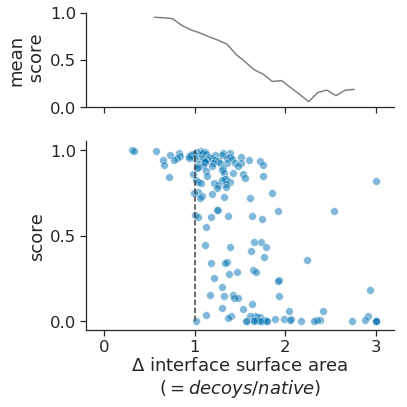

all_heavy_buns


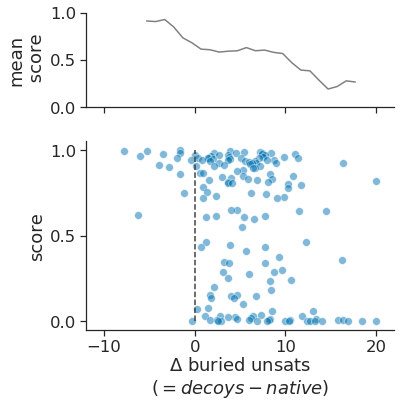

In [36]:
metrics_dict = {
    'dsasa_all' : {
        'window_size' : 0.5,
        'step_size' : 0.1,
        'baseline' : 1,
        'xticks' : np.arange(0, 4, 1),
        'xrange' : [-0.2, 3.2],
        'xlabel' : '$\Delta$ interface surface area\n$(=decoys / native)$',
    },
    'all_heavy_buns' : {
        'window_size' : 5,
        'step_size' : 1,
        'baseline' : 0,
        'xticks' : np.arange(-10, 30, 10),
        'xrange' : [-12, 22],
        'xlabel' : '$\Delta$ buried unsats\n$(=decoys - native)$',
    },
}
for (metric, metric_dict) in metrics_dict.items():

    # Get the average discrimination score of sliding windows
    # along the range of the metric
    print(metric)
    window_size = metric_dict['window_size']
    step_size = metric_dict['step_size']
    min_val = df[metric].min()
    max_val = df[metric].max()
    xrange = metric_dict['xrange']
    assert xrange[0] < min_val
    assert xrange[1] > max_val
    left_bounds = np.arange(
        min_val,
        (max_val-window_size)+step_size,
        step_size
    )
    mean_vals_dict = {
        key : []
        for key in ['center_point', 'mean_score']
    }
    for left_bound in left_bounds:
        data = df[df[metric].between(left_bound, left_bound + window_size)]
        mean_vals_dict['center_point'].append(left_bound + window_size/2)
        mean_vals_dict['mean_score'].append(data['ds'].mean())
    mean_vals_df = pandas.DataFrame(mean_vals_dict)

    # Plot line plot of mean discrimination score
    (fig, axs) = plt.subplots(
        nrows=2, figsize=[6,6], sharex=True,
        gridspec_kw={'height_ratios': [1, 2]}
    )
    sns.lineplot(
        x='center_point', y='mean_score', data=mean_vals_df,
        color='0.5', ax=axs[0]
    )
    axs[0].set(
        xlabel='',
        xticks=metric_dict['xticks'], xlim=xrange,
        ylabel='mean\n score',
        ylim=[0,1], yticks=[0, 0.5, 1]
    )

    # Plot scatter plot of metric vs discrimination score
    sns.scatterplot(
        x=metric, y='ds', data=df,
        s=60, alpha=0.5, ax=axs[1]
    )
    axs[1].plot(
        [metric_dict['baseline'], metric_dict['baseline']],
        [0,1], ls='--', c='0.25'
    )
    axs[1].set(
        #xlim=[min_bin_val-(bin_size/2), max_bin_val+(bin_size/2)],
        xticks=metric_dict['xticks'], xlim=xrange,
        xlabel=metric_dict['xlabel'],
        ylabel='score',
        yticks=[0, 0.5, 1]
    )
    #plt.xticks(rotation=90)
    plt.tight_layout()
    sns.despine()
    plt.show()

In [26]:
df[
    #df['dsasa_all'].between(2, 10) &
    #df['all_heavy_buns'].between(2, 10) &
    #df['ds'].between(0.95, 1) &
    df['native'].isin(['1SBB', '1I9R', '1H9D', '1HIA', '4CPA']) &
    ~df['dsasa_all'].isnull()
].sort_values('dsasa_all', ascending=False).head()

,native,dsasa_all,dsasa_polar,dsasa_non_polar,all_buns,all_heavy_buns,ds
86,4CPA,0.904376,0.699422,1.026486,9.875000,4.725000,0.260931
117,1HIA,0.763978,0.744400,0.775459,-2.571429,-2.528571,0.056103
95,1H9D,0.246979,0.337449,0.194251,0.228571,-1.571429,0.000092
49,1SBB,0.200427,0.260282,0.163771,-3.377778,-2.333333,0.000074
146,1I9R,0.176604,0.188408,0.163681,-6.800000,-4.700000,0.000013


In [102]:
df.sort_values('dsasa_all')

,native,dsasa_all,dsasa_polar,dsasa_non_polar,all_buns,ds,bin
87,1K74,0.306554,0.311796,0.302813,-1.636364,0.999468,0.4
127,2OZA,0.334757,0.265080,0.378759,-12.000000,0.998747,0.4
30,1SBB,0.569694,0.730275,0.469243,-12.866667,0.993109,0.4
137,1H9D,0.646950,0.742900,0.591364,15.085714,0.943410,0.8
145,4CPA,0.667558,0.559627,0.730861,-2.766667,0.914556,0.8
121,1PPE,0.720502,0.715028,0.723942,0.863636,0.844859,0.8
64,1FCC,0.728789,0.752768,0.710576,4.516667,0.972087,0.8
57,1CLV,0.776058,0.911627,0.697614,3.680000,0.943135,0.8
5,1R8S,0.805293,0.850142,0.780383,4.476923,0.952251,0.8
59,1GCQ,0.831032,0.690490,0.926086,-1.147368,0.986688,0.8


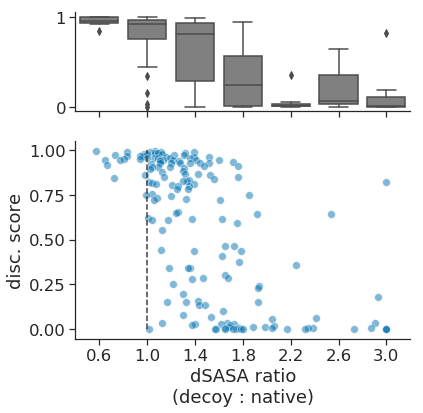

In [35]:
metric = 'dsasa_all'
bin_size = 0.4
min_val = 0.6 # df[metric].min()
max_val = df[metric].max()

bins = np.arange(min_val, max_val+bin_size, bin_size)

def find_bin(x, bins, bin_size):
    for bin_i in bins:
        if x <= (bin_i + (bin_size/2)):
            return round(bin_i, 2)
    
df['bin'] = df[metric].apply(lambda x: find_bin(x, bins, bin_size))
min_bin_val = df['bin'].min()
max_bin_val = df['bin'].max()

(fig, axs) = plt.subplots(
    nrows=2, figsize=[6,6],
    gridspec_kw={'height_ratios': [1, 2]}
)
sns.boxplot(x='bin', y='ds', data=df, color='0.5', ax=axs[0])
axs[0].axes.xaxis.set_ticklabels([])
axs[0].set(xlabel='', ylabel='')
sns.scatterplot(
    x=metric, y='ds', data=df,
    s=60, alpha=0.5, ax=axs[1]
)
axs[1].plot([1,1], [0,1], ls='--', c='0.25')
axs[1].set(
    xlim=[min_bin_val-(bin_size/2), max_bin_val+(bin_size/2)],
    xticks=np.arange(min_bin_val, max_bin_val+bin_size, bin_size),
    xlabel='dSASA ratio\n(decoy : native)',
    ylabel='disc. score'
    #yticks=[0, 1]
)
#plt.xticks(rotation=90)
sns.despine()
plt.show()

In [2]:
import pyrosetta
import pyrosetta.rosetta

# Initialize PyRosetta
flags = [
    '-mute all', '-mute core', '-mute protocols',
    '-ignore_unrecognized_res',
    '-read_only_ATOM_entries',
    '-in:file:silent_struct_type binary',
    '-crystal_refine true',
    '-silent_read_through_errors'
]
pyrosetta.init(extra_options=' '.join(flags))

In [3]:
# Set up a score function in `PyRosetta`
sf = pyrosetta.get_fa_scorefxn()
def fix_scorefxn(sfxn, allow_double_bb=False):
    opts = sfxn.energy_method_options()
    opts.hbond_options().decompose_bb_hb_into_pair_energies(True)
    opts.hbond_options().bb_donor_acceptor_check(not allow_double_bb)
    sfxn.set_energy_method_options(opts)
fix_scorefxn(sf)

In [4]:
def pull_apart_chains(pose):

    # Copy pose
    split_pose = pose.clone()

    # Get an arbitrary translation vector that is
    # very large in magnitude
    res = split_pose.residue(1)
    xyz_i = res.xyz(1)
    xyz_j = res.xyz(2)
    dv = xyz_j - xyz_i
    translation_vector = dv.normalize(5000)

    # Translate all atoms that aren't in chain A and then
    # return the split pose
    for res_n in list(range(1, split_pose.size()+1)):
        res = split_pose.residue(res_n)
        chain = split_pose.pdb_info().chain(res_n)
        if chain == 'A':
            continue
        for atom_n in list(range(1, res.natoms()+1)):
            res.set_xyz(
                atom_n,
                res.xyz(atom_n) + translation_vector
            )
    
    return split_pose

In [5]:
def compute_delta_interface_sasa(input_silent_file, sasa_probe_radius):

    # Loop over each pose and record per-atom SASAs
    sasa_dict = {
        key : []
        for key in [
            'tag',
            'res_n', 'res_name', 'atom_n', 'atom_name', 'atom_type_name',
            'atom_x_bound', 'atom_x_unbound',
            'sasa_bound', 'sasa_unbound',
            'atom_is_donor', 'atom_is_acceptor', 'atom_is_polar_hydrogen',
        ]
    }
    sfd = pyrosetta.rosetta.core.io.silent.SilentFileData(
        pyrosetta.rosetta.core.io.silent.SilentFileOptions()
    )
    sfd.read_file(input_silent_file)
    for tag in sfd.tags():

        # Read in pose and compute SASA for all atoms
        ss = sfd.get_structure(tag)
        pose = pyrosetta.Pose()
        ss.fill_pose(pose)
        sf(pose)
        #bound_sasa_calc = \
            #pyrosetta.rosetta.protocols.vardist_solaccess.VarSolDistSasaCalculator()
        bound_sasa_calc = pyrosetta.rosetta.core.scoring.sasa.SasaCalc()
        bound_sasa_calc.set_probe_radius(sasa_probe_radius)
        bound_sasa_map = bound_sasa_calc.calculate(pose)
        bound_sasa_map = bound_sasa_calc.get_atom_sasa()

        # Next, pull apart the chains and compute SASA in the
        # unbound state
        split_pose = pull_apart_chains(pose)
        sf(split_pose)
        #unbound_sasa_calc = \
        #    pyrosetta.rosetta.protocols.vardist_solaccess.VarSolDistSasaCalculator()
        unbound_sasa_calc = pyrosetta.rosetta.core.scoring.sasa.SasaCalc()
        unbound_sasa_calc.set_probe_radius(sasa_probe_radius)
        unbound_sasa_map = unbound_sasa_calc.calculate(split_pose)
        unbound_sasa_map = unbound_sasa_calc.get_atom_sasa()

        # Record data for each atom
        for res_n in list(range(1, pose.size()+1)):
            res = pose.residue(res_n)
            for atom_n in list(range(1, res.natoms()+1)):

                atom_type = res.atom_type(atom_n)
                atom_name = res.atom_name(atom_n).strip()
                atom_type_name = atom_type.atom_type_name()

                atom_id = pyrosetta.AtomID(atom_n, res_n)
                #atom_hbonds = hbond_set.atom_hbonds(
                #    atom_id, include_only_allowed=False
                #)
                sasa_bound = bound_sasa_map[res_n][atom_n]
                sasa_unbound = unbound_sasa_map[res_n][atom_n]

                sasa_dict['tag'].append(os.path.basename(tag))
                sasa_dict['res_n'].append(res_n)
                sasa_dict['res_name'].append(res.name1())
                sasa_dict['atom_n'].append(atom_n)
                sasa_dict['atom_name'].append(atom_name)
                sasa_dict['atom_type_name'].append(atom_type_name)
                sasa_dict['atom_x_bound'].append(res.xyz(atom_n).x)
                sasa_dict['atom_x_unbound'].append(split_pose.residue(res_n).xyz(atom_n).x)
                sasa_dict['sasa_bound'].append(sasa_bound)
                sasa_dict['sasa_unbound'].append(sasa_unbound)
                sasa_dict['atom_is_donor'].append(atom_type.is_donor())
                sasa_dict['atom_is_acceptor'].append(atom_type.is_acceptor())
                sasa_dict['atom_is_polar_hydrogen'].append(atom_type.is_polar_hydrogen())

    sasa_df = pandas.DataFrame(sasa_dict)
    sasa_df['polar'] = sasa_df[[
        'atom_is_donor', 'atom_is_acceptor',
        'atom_is_polar_hydrogen'
    ]].any(axis=1)
    sasa_df['delta_sasa'] = sasa_df['sasa_bound'] - sasa_df['sasa_unbound']
    
    # Next, compute the total change in SASA across all atoms
    # upon binding. Do same for just polar or just non-polar
    # atoms.
    delta_sasa_dict = {
        key : []
        for key in ['pdb', 'dsasa_all', 'dsasa_polar', 'dsasa_non_polar']
    }
    tags = list(set(sasa_df['tag']))
    for tag in tags:

        delta_sasa_dict['pdb'].append(tag)

        data = sasa_df[sasa_df['tag'] == tag]
        delta_sasa_dict['dsasa_all'].append(sum(data['delta_sasa']))

        data = sasa_df[
            (sasa_df['tag'] == tag) &
            (sasa_df['polar'] == True)
        ]
        delta_sasa_dict['dsasa_polar'].append(sum(data['delta_sasa']))

        data = sasa_df[
            (sasa_df['tag'] == tag) &
            (sasa_df['polar'] == False)
        ]
        delta_sasa_dict['dsasa_non_polar'].append(sum(data['delta_sasa']))

    delta_sasa_df = pandas.DataFrame(delta_sasa_dict)
    
    return delta_sasa_df